<a href="https://colab.research.google.com/github/AKASH4671/Stock-Return-Forecasting-Using-LSTM-and-Machine-Learning/blob/main/notebooks/03_LSTM_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install + Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import os


**Load Data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

csv_path = '/content/drive/MyDrive/Colab Notebooks/Finance Projects/stock-price-prediction-ml/data/tsla_preprocessed.csv'
df = pd.read_csv(csv_path)

df.dropna(inplace=True)

features = ['Lag_1', 'Lag_2', 'Lag_3']
target = 'Return'

X = df[features].values
y = df[target].values.reshape(-1, 1)


Mounted at /content/drive


**Normalize Inputs**

In [3]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)


**Create Time Series Data for LSTM**

In [4]:
def create_sequences(X, y, time_steps=5):
    Xs, ys = [], []
    for i in range(time_steps, len(X)):
        Xs.append(X[i-time_steps:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

time_steps = 5
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

# Train-test split (no shuffle!)
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]


**Define and Train LSTM Model**

In [5]:
model = Sequential()
model.add(LSTM(units=64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[es],
    verbose=1
)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0527 - val_loss: 0.0066
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0132 - val_loss: 0.0067
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0111 - val_loss: 0.0067
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0111 - val_loss: 0.0070
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0119 - val_loss: 0.0065
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0112 - val_loss: 0.0065
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0105 - val_loss: 0.0066
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0092 - val_loss: 0.0068
Epoch 9/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0112 - val_loss: 0.0065
Epoch 10/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0111 - val_loss: 0.0065
Epoch 11/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093 - val_loss: 0.0071
Epoch 12/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0115 - val_l

**Predict and Inverse Scale**

In [6]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"▸ LSTM Performance:")
print(f"   MAE : {mae:.6f}")
print(f"   RMSE: {rmse:.6f}")
print(f"   R²  : {r2:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
▸ LSTM Performance:
   MAE : 0.031643
   RMSE: 0.043762
   R²  : -0.0201


**Plot Actual vs Predicted**

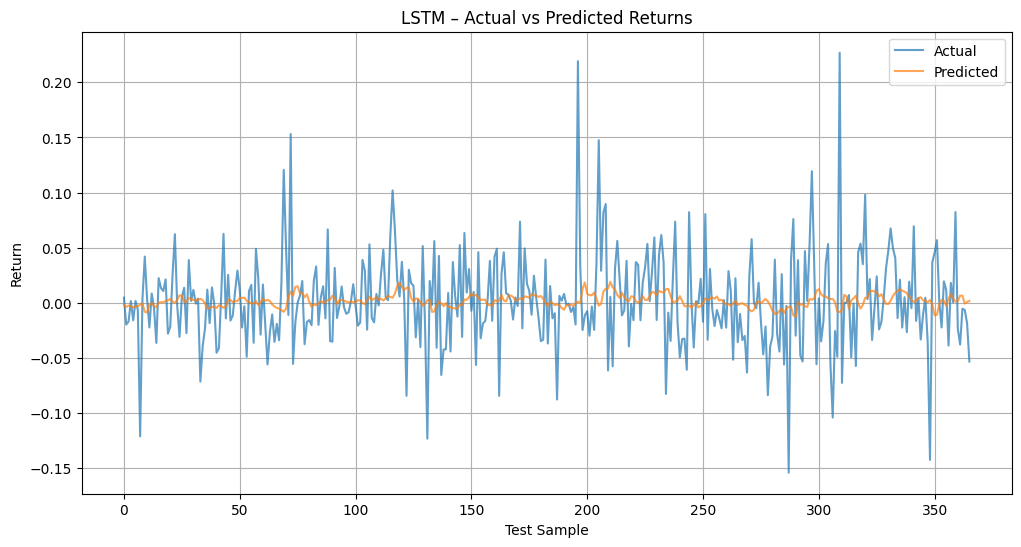

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.title("LSTM – Actual vs Predicted Returns")
plt.xlabel("Test Sample")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.show()


**Save Model + Predictions**

In [8]:
save_dir = '/content/drive/MyDrive/Colab Notebooks/Finance Projects/stock-price-prediction-ml/data/models/lstm'
predictions_save_dir = '/content/drive/MyDrive/Colab Notebooks/Finance Projects/stock-price-prediction-ml/data'


if not os.path.exists(save_dir):
    os.makedirs(save_dir)

if not os.path.exists(predictions_save_dir):
    os.makedirs(predictions_save_dir)


model.save(os.path.join(save_dir, 'lstm_model.h5'))
joblib.dump(scaler_X, os.path.join(save_dir, 'lstm_scaler_X.pkl'))
joblib.dump(scaler_y, os.path.join(save_dir, 'lstm_scaler_y.pkl'))

pred_df = pd.DataFrame({
    'Actual': y_true.flatten(),
    'LSTM_Pred': y_pred.flatten()
})
pred_df.to_csv(os.path.join(predictions_save_dir, 'lstm_predictions.csv'), index=False)

print("✔️ Model and predictions saved.")

✔️ Model and predictions saved.


**✅ What we’re Predicting**

we are not predicting stock prices (e.g., ₹750), but rather:

📉 Next-day stock return → the percentage change in stock price from today to tomorrow.

The model outputs values like:

| Day | Actual Return (%) | Predicted Return (%) |
| --- | ----------------- | -------------------- |
| D1  | +0.45             | +0.41                |
| D2  | –0.30             | –0.28                |
| D3  | +0.15             | +0.05                |

This means:

A prediction of +0.5% = "The model expects the stock to go up slightly tomorrow"

A prediction of –0.3% = "The model expects a small drop tomorrow"

In [9]:
print(pred_df.head())

     Actual  LSTM_Pred
0  0.004660  -0.002051
1 -0.019826  -0.003741
2 -0.017026  -0.002647
3  0.001463  -0.002999
4 -0.015976  -0.004241


In [10]:
pred_df['Actual (%)'] = pred_df['Actual'] * 100
pred_df['Predicted (%)'] = pred_df['LSTM_Pred'] * 100
print(pred_df.head())


     Actual  LSTM_Pred  Actual (%)  Predicted (%)
0  0.004660  -0.002051    0.465989      -0.205135
1 -0.019826  -0.003741   -1.982630      -0.374099
2 -0.017026  -0.002647   -1.702620      -0.264668
3  0.001463  -0.002999    0.146308      -0.299918
4 -0.015976  -0.004241   -1.597624      -0.424082


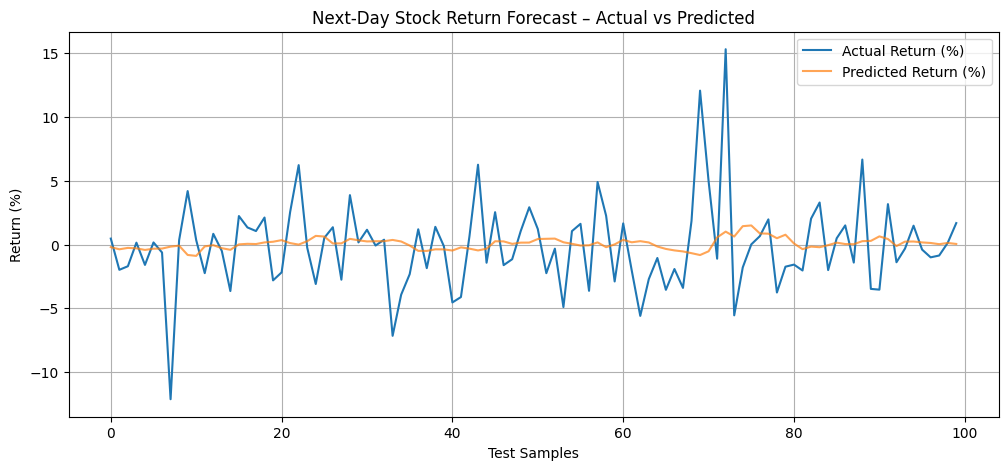

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(pred_df['Actual (%)'][:100], label='Actual Return (%)')
plt.plot(pred_df['Predicted (%)'][:100], label='Predicted Return (%)', alpha=0.7)
plt.title("Next-Day Stock Return Forecast – Actual vs Predicted")
plt.xlabel("Test Samples")
plt.ylabel("Return (%)")
plt.legend()
plt.grid(True)
plt.show()
